In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Data Preparation

Load the data and track the metrics

In [3]:
data = pd.read_csv("./Datasets/sales_data.csv")

In [4]:
data.isnull().sum()

Date                     0
Product                  0
Region                   0
Sales                    0
Customer_Age             0
Customer_Gender          0
Customer_Satisfaction    0
dtype: int64

In [5]:
data["Date"] = pd.to_datetime(data["Date"])

In [6]:
data.describe()

,Date,Sales,Customer_Age,Customer_Satisfaction
count,2500,2500.000000,2500.000000,2500.000000
mean,2025-06-03 12:00:00,553.288000,43.332800,3.025869
min,2022-01-01 00:00:00,100.000000,18.000000,1.005422
25%,2023-09-17 18:00:00,324.750000,31.000000,2.056014
50%,2025-06-03 12:00:00,552.500000,43.000000,3.049480
75%,2027-02-18 06:00:00,779.000000,56.000000,4.042481
max,2028-11-04 00:00:00,999.000000,69.000000,4.999006
std,NaN,260.101758,14.846758,1.156981


# Knowledge base Creation

## **Create a summary function combining all relevant statistical analysis.**

In [9]:
def generate_advanced_data_summary(df):
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Sales Analysis
    total_sales = df['Sales'].sum()
    avg_sale = df['Sales'].mean()
    median_sale = df['Sales'].median()
    sales_std = df['Sales'].std()

    # Time-based Analysis
    df['Month'] = df['Date'].dt.to_period('M')
    monthly_sales = df.groupby('Month', observed=False)['Sales'].sum().sort_values(ascending=False)
    best_month = monthly_sales.index[0]
    worst_month = monthly_sales.index[-1]

    # Product Analysis
    product_sales = df.groupby('Product', observed=False)['Sales'].agg(['sum', 'count', 'mean'])
    top_product = product_sales['sum'].idxmax()
    most_sold_product = product_sales['count'].idxmax()

    # Regional Analysis
    region_sales = df.groupby('Region', observed=False)['Sales'].sum().sort_values(ascending=False)
    best_region = region_sales.index[0]
    worst_region = region_sales.index[-1]

    # Customer Analysis
    avg_satisfaction = df['Customer_Satisfaction'].mean()
    satisfaction_std = df['Customer_Satisfaction'].std()

    age_bins = [0, 25, 35, 45, 55, 100]
    age_labels = ['18-25', '26-35', '36-45', '46-55', '55+']
    df['Age_Group'] = pd.cut(df['Customer_Age'], bins=age_bins, labels=age_labels, right=False)
    age_group_sales = df.groupby('Age_Group', observed=False)['Sales'].mean().sort_values(ascending=False)
    best_age_group = age_group_sales.index[0]

    # Gender Analysis
    gender_sales = df.groupby('Customer_Gender', observed=False)['Sales'].mean()

    summary = f"""
    Advanced Sales Data Summary:

    Overall Sales Metrics:
    - Total Sales: ${total_sales:,.2f}
    - Average Sale: ${avg_sale:.2f}
    - Median Sale: ${median_sale:.2f}
    - Sales Standard Deviation: ${sales_std:.2f}

    Time-based Analysis:
    - Best Performing Month: {best_month}
    - Worst Performing Month: {worst_month}

    Product Analysis:
    - Top Selling Product (by value): {top_product}
    - Most Frequently Sold Product: {most_sold_product}

    Regional Performance:
    - Best Performing Region: {best_region}
    - Worst Performing Region: {worst_region}

    Customer Insights:
    - Average Customer Satisfaction: {avg_satisfaction:.2f}/5
    - Customer Satisfaction Standard Deviation: {satisfaction_std:.2f}
    - Best Performing Age Group: {best_age_group}
    - Gender-based Average Sales: Male=${gender_sales['Male']:.2f}, Female=${gender_sales['Female']:.2f}


    Key Observations:
    1. The sales data shows significant variability with a standard deviation of ${sales_std:.2f}.
    2. The {best_age_group} age group shows the highest average sales.
    3. Regional performance varies significantly, with {best_region} outperforming {worst_region}.
    4. The most valuable product ({top_product}) differs from the most frequently sold product ({most_sold_product}), suggesting potential for targeted marketing strategies.
    """

    return summary


# LLM application development

### Advanced data summary

In [10]:
advanced_summary = generate_advanced_data_summary(data)

## Integration with RAG System

In [11]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [12]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain, RetrievalQA
from langchain.memory import ConversationBufferMemory
from langchain_community.document_loaders import PyPDFLoader
from langchain.chains import ConversationalRetrievalChain
import os
import openai

In [13]:
doc = Document(page_content=advanced_summary, metadata = {'source': 'advanced_summary.txt'})

In [14]:
pdf_folder = 'Datasets/Capstone_pdfs'
documents = []
if os.path.exists(pdf_folder):
   for file in os.listdir(pdf_folder):
       if file.endswith('.pdf'):
           loader = PyPDFLoader(os.path.join(pdf_folder, file))
           documents.extend(loader.load())
else:
   print(f"The folder '{pdf_folder}' does not exist.")

In [15]:
all_docs = [doc] + documents

In [16]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size= 500,
    chunk_overlap=100
)
chunked_docs = text_splitter.split_documents(all_docs)

In [17]:
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunked_docs, embeddings)
retriever = vectorstore.as_retriever()

/var/folders/q3/804jvxv50k900sffyj_lk9yc0000gn/T/ipykernel_29306/3327428020.py:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()


## Memory Setup

In [18]:
memory = ConversationBufferMemory(memory_key = "chat_history", return_messages=True)

/var/folders/q3/804jvxv50k900sffyj_lk9yc0000gn/T/ipykernel_29306/3927247157.py:1: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key = "chat_history", return_messages=True)


## RAG system setup

In [19]:
llm = OpenAI(model_name="gpt-3.5-turbo-instruct")

master_qa = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    output_key="answer"  # 👈 this tells memory what to track
)


/var/folders/q3/804jvxv50k900sffyj_lk9yc0000gn/T/ipykernel_29306/3706694427.py:1: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI(model_name="gpt-3.5-turbo-instruct")


In [20]:
question = "Which region had the highest sales?"
response = master_qa.invoke({"question": question})

print(response)

{'question': 'Which region had the highest sales?', 'chat_history': [HumanMessage(content='Which region had the highest sales?', additional_kwargs={}, response_metadata={}), AIMessage(content=' West', additional_kwargs={}, response_metadata={})], 'answer': ' West'}


# Adding Tools to RAG for Extended Insights

In [21]:
from langchain.agents import Tool, initialize_agent, AgentType
from langchain.utilities import SerpAPIWrapper
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.agents.load_tools import load_tools
import os

In [22]:
load_dotenv()

SERPAPI_API_KEY = os.getenv("SERPAPI_API_KEY")
os.environ["SERPAPI_API_KEY"] = SERPAPI_API_KEY

## Wikipedia for additional information

In [23]:
wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool = Tool(
    name="Wikipedia",
    func=wiki.run,
    description="Useful for answering general knowledge questions using Wikipedia."
)


## Google Websearch results (Serp API)

In [24]:
serp_tool = Tool(
    name = "SerpAPI",
    func = SerpAPIWrapper().run,
    description = "Use this to get the recent or trending web results"
)


In [25]:
math_tool = load_tools(["llm-math"], llm = llm)
math_tool = math_tool[0]


## Using the RAG as a tool

In [26]:
rag_tool = Tool(
    name="RAGSearch",
    func=lambda q: master_qa.invoke({"question": q, "chat_history": []})["answer"],
    description = "Use this to answer questions from internal PDFs and sales data."
)


In [27]:
tools = [rag_tool,wiki_tool,serp_tool,math_tool]

In [28]:
agent_chain = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION,
    memory=memory,
    verbose=True
)

/var/folders/q3/804jvxv50k900sffyj_lk9yc0000gn/T/ipykernel_29306/1763872957.py:1: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent_chain = initialize_agent(


In [30]:
response = agent_chain.run("explain which performed better: east or west region ")
print(response)



> Entering new AgentExecutor chain...


{
    "action": "Final Answer",
    "action_input": "The West region had higher sales performance compared to the East region."
}

> Finished chain.
The West region had higher sales performance compared to the East region.


# Adding Support for Data Visualization
Creating plotting functions to serve as additional tools to create data visualization plots and graphs based on the provided data

In [31]:
import matplotlib.pyplot as plt
from langchain.agents import AgentExecutor, LLMSingleActionAgent
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor
from langchain.evaluation.qa import QAEvalChain
from langchain.prompts import StringPromptTemplate
from langchain.schema import AgentAction, AgentFinish
from typing import List, Union

In [32]:
def plot_product_category_sales():
    product_cat_sales = data.groupby('Product')['Sales'].sum().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    product_cat_sales.plot(kind='bar')
    plt.title('Sales Distribution by Product')
    plt.xlabel('Product')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()

def plot_sales_trend():
    plt.figure(figsize=(10, 6))
    data.groupby('Date')['Sales'].sum().plot()
    plt.title('Daily Sales Trend')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')

def plot_total_sales_by_region():
    region_sales = data.groupby('Region')['Sales'].sum().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    region_sales.plot(kind='bar', color='red')
    plt.title('Total Sales by Region')
    plt.xlabel('Region')
    plt.ylabel('Total Sales')
    # plt.xticks(rotation=45)
    plt.tight_layout()
    
def plot_mean_satisfaction_by_region():
    region_satisfaction = data.groupby('Region')['Customer_Satisfaction'].mean().sort_values()
    plt.figure(figsize=(10, 6))
    region_satisfaction.plot(kind='bar', color='orange')
    plt.title('Average Customer Satisfaction by Region')
    plt.xlabel('Region')
    plt.ylabel('Avg. Satisfaction')
    # plt.xticks(rotation=45)
    plt.tight_layout()
    
def plot_mean_sales_by_region_and_product():
    product_sales = data.groupby('Product')['Sales'].mean()

    product_sales.plot(kind='bar', color='mediumseagreen', figsize=(6, 4))
    plt.title('Average Sales per Product')
    plt.xlabel('Product')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
def plot_mean_satisfaction_by_gender():
    gender_satisfaction = data.groupby('Customer_Gender')['Customer_Satisfaction'].mean()
    plt.figure(figsize=(8, 6))
    gender_satisfaction.plot(kind='bar', color='purple')
    plt.title('Avg. Customer Satisfaction by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Avg. Satisfaction')
    plt.tight_layout()
    
def plot_mean_satisfaction_by_group():
    df = data.copy(deep=True)
    
    bins = [18, 25, 35, 45, 55, 65]
    labels = ['18–24', '25–34', '35–44', '45–54', '55–64']
    df['Age_Group'] = pd.cut(df['Customer_Age'], bins=bins, labels=labels)
    
    age_group_satisfaction = df.groupby('Age_Group')['Customer_Satisfaction'].mean()
    
    plt.figure(figsize=(10, 6))

    age_group_satisfaction.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['pink', 'lightblue', 'yellow', 'lightgreen', 'orange', 'teal'])
    
    plt.title('Avg. Customer Satisfaction by Age Group')
    # plt.ylabel('')
    plt.tight_layout()

def plot_total_sales_by_age_group():
    df = data.copy(deep=True)
    
    bins = [18, 25, 35, 45, 55, 65]
    labels = ['18–24', '25–34', '35–44', '45–54', '55–64']
    df['Age_Group'] = pd.cut(df['Customer_Age'], bins=bins, labels=labels)

    sales_by_group = df.groupby('Age_Group')['Sales'].sum()
    
    plt.figure(figsize=(6, 6))
    sales_by_group.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['red', 'blue', 'yellow', 'lightgreen', 'orange', 'violet'])
    plt.title('Sales Distribution by Age Group')
    # plt.ylabel('')
    plt.tight_layout()

def plot_total_sales_by_region_and_gender():
    sales_by_region_gender = data.groupby(['Region', 'Customer_Gender'])['Sales'].sum().unstack(fill_value=0)

    sales_by_region_gender.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'lightpink'])
    plt.title('Total Sales by Region and Gender')
    plt.xlabel('Region')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=0)
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()

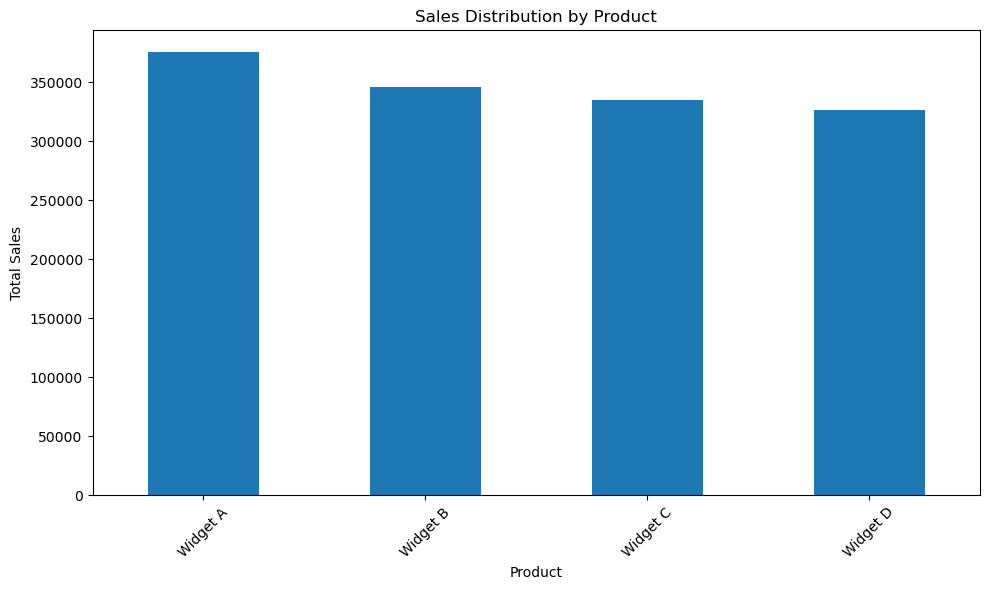

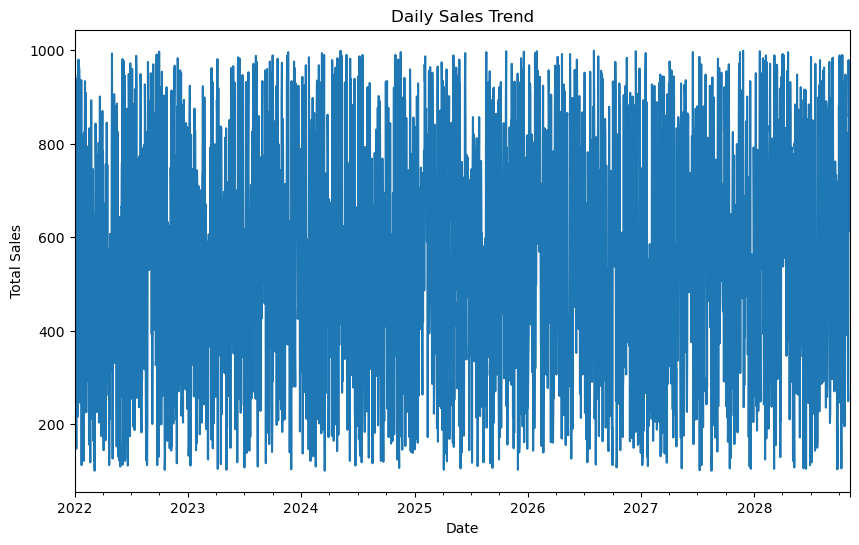

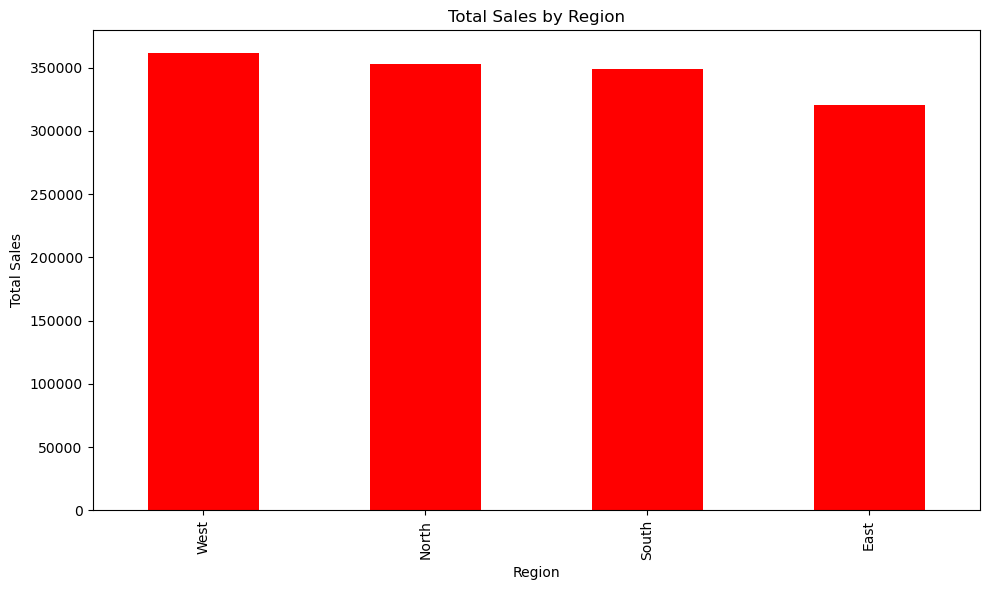

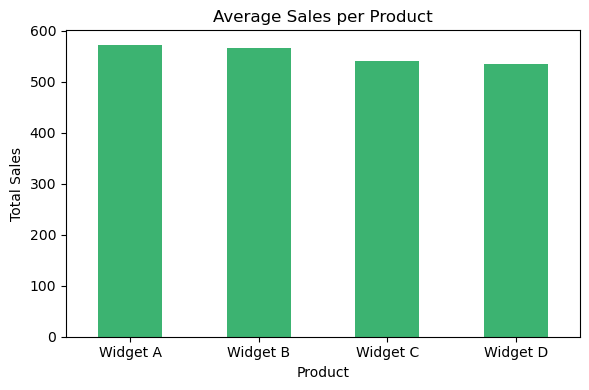

/var/folders/q3/804jvxv50k900sffyj_lk9yc0000gn/T/ipykernel_29306/1665748511.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_satisfaction = df.groupby('Age_Group')['Customer_Satisfaction'].mean()
/var/folders/q3/804jvxv50k900sffyj_lk9yc0000gn/T/ipykernel_29306/1665748511.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_group = df.groupby('Age_Group')['Sales'].sum()


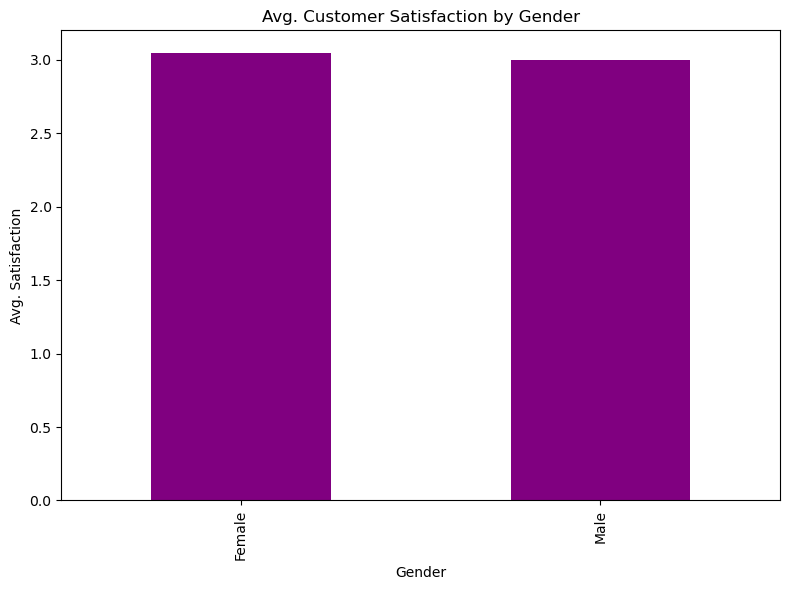

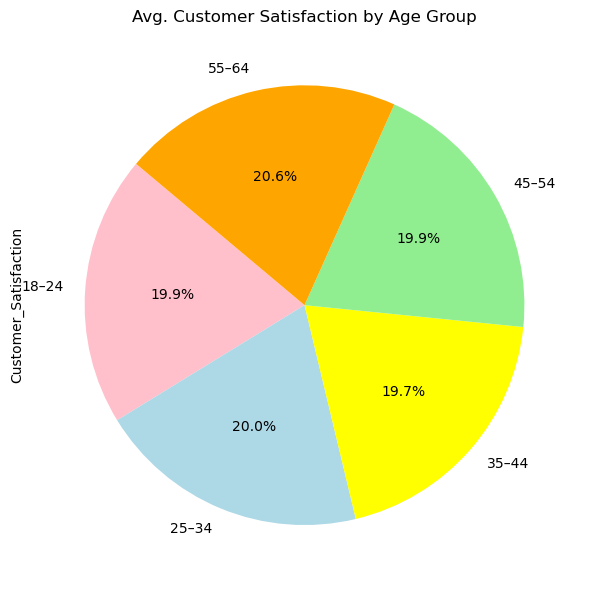

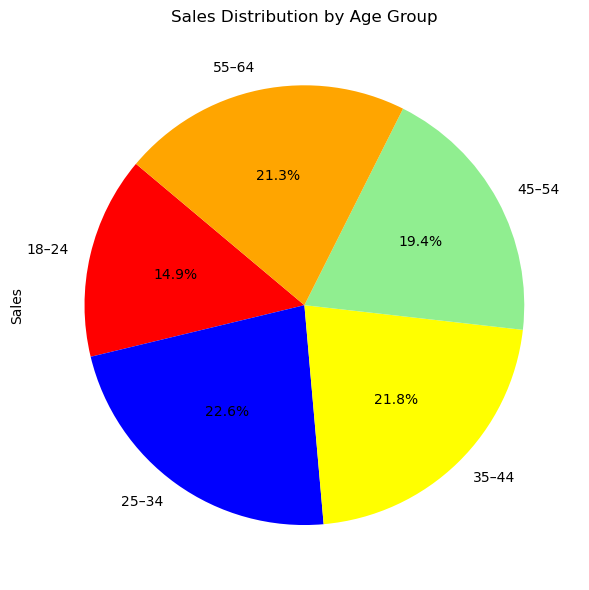

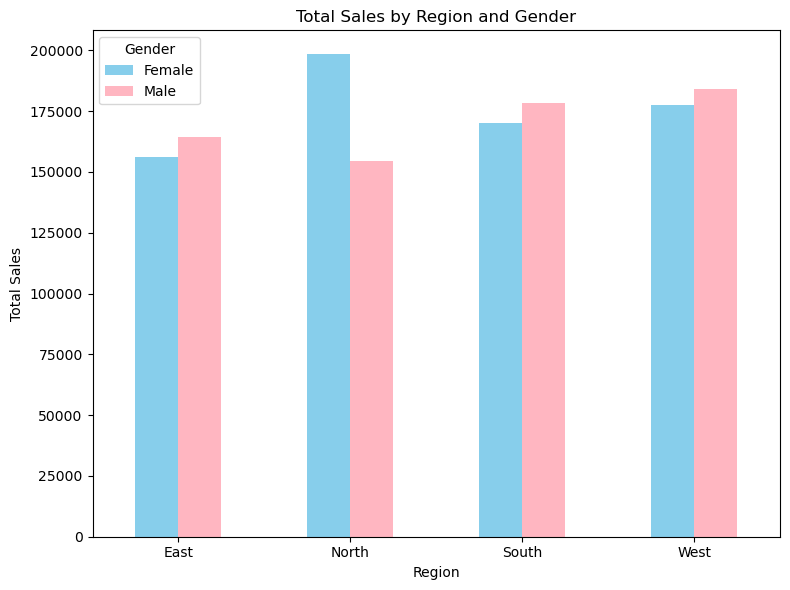

In [33]:
plot_product_category_sales()
plot_sales_trend()  
plot_total_sales_by_region()
plot_mean_satisfaction_by_region()
plot_mean_sales_by_region_and_product()
plot_mean_satisfaction_by_gender()
plot_mean_satisfaction_by_group()
plot_total_sales_by_age_group()
plot_total_sales_by_region_and_gender()

In [34]:
ProductCategorySalesPlot = Tool(        
        name="ProductCategorySalesPlot",
        func=lambda x: plot_product_category_sales(),
        description="Generates a plot of sales distribution by product category"
    )

SalesTrendPlot = Tool(
        name="SalesTrendPlot",
        func=lambda x: plot_sales_trend(),
        description="Generates a plot of the daily sales trend"
    )

######

SalesByRegionPlot = Tool(
    name="SalesByRegionPlot",
    func=lambda x: plot_total_sales_by_region(),
    description="Generates a plot of total sales by region"
)

CustomerSatisfactionByRegionPlot = Tool(
    name="CustomerSatisfactionByRegionPlot",
    func=lambda x: plot_mean_satisfaction_by_region(),
    description="Generates a plot of average customer satisfaction by region"
)

SalesByRegionProductPlot = Tool(
    name="SalesByRegionProductPlot",
    func=lambda x: plot_mean_sales_by_region_and_product(),
    description="Generates a plot of average sales by region and product"
)

CustomerSatisfactionByGenderPlot = Tool(
    name="CustomerSatisfactionByGenderPlot",
    func=lambda x: plot_mean_satisfaction_by_gender(),
    description="Generates a bar chart of average customer satisfaction by gender"
)

CustomerSatisfactionByAgeGroupPlot = Tool(
    name="CustomerSatisfactionByAgeGroupPlot",
    func=lambda x: plot_mean_satisfaction_by_group(),
    description="Generates a bar chart of average customer satisfaction grouped by age ranges"
)

SalesByAgeGroupPlot = Tool(
    name="SalesByAgeGroupPlot",
    func=lambda x: plot_total_sales_by_age_group(),
    description="Generates a pie chart of total sales grouped by age ranges"
)

SalesByRegionGenderPlot = Tool(
    name="SalesByRegionGenderPlot",
    func=lambda x: plot_total_sales_by_region_and_gender(),
    description="Generates a bar chart of total sales grouped by regions for each gender category"
)

#####

AdvancedSummary = Tool(
        name="AdvancedSummary",
        func=lambda x: advanced_summary,
        description="Provides the advanced summary of sales data"
    )

In [35]:
tools = [
            rag_tool,
            wiki_tool,
            serp_tool,
            math_tool,
            ProductCategorySalesPlot,
            SalesTrendPlot,
            SalesByRegionPlot,
            CustomerSatisfactionByRegionPlot,
            SalesByRegionProductPlot,
            CustomerSatisfactionByGenderPlot,
            CustomerSatisfactionByAgeGroupPlot,
            SalesByAgeGroupPlot,
            SalesByRegionGenderPlot,
            AdvancedSummary
        ]

# Chain prompts
Creating a prompt template to process inputs

In [36]:
prefix = """You are an AI sales analyst with access to advanced sales data and a RAG system.
Use the following tools to answer the user's questions:"""

suffix = """Begin!"

{chat_history}
Human: {input}
AI: Let's approach this step-by-step:
{agent_scratchpad}"""

In [37]:
prompt = ZeroShotAgent.create_prompt(
    tools,
    prefix=prefix,
    suffix=suffix,
    input_variables=["input", "chat_history", "agent_scratchpad"]
)

In [38]:
from langchain.chains import LLMChain

llm_chain = LLMChain(llm=llm, prompt=prompt)
agent = ZeroShotAgent(llm_chain=llm_chain, tools=tools, verbose=True)
agent_chain = AgentExecutor.from_agent_and_tools(agent=agent, 
                                                 tools=tools, 
                                                 verbose=True, 
                                                 handle_parsing_errors=True)

/var/folders/q3/804jvxv50k900sffyj_lk9yc0000gn/T/ipykernel_29306/1695178653.py:3: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(llm=llm, prompt=prompt)
/var/folders/q3/804jvxv50k900sffyj_lk9yc0000gn/T/ipykernel_29306/1695178653.py:4: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos



> Entering new AgentExecutor chain...
Thought: First, we need to gather the latest geopolitical developments and their potential impact on our sales. We can do this by using SerpAPI to search for relevant news articles and Wikipedia to retrieve background information on key events.
Action: SerpAPI
Action Input: query = "latest geopolitical developments"
Observation: ['This week we cover the new US-EU trade deal, ongoing fighting at the Thailand-Cambodia border, signs of a new permanent partition of Sudan, and the geopolitical ...', 'The world is changing. Geopolitical fragmentation is being fueled by COVID-19, the war in Ukraine, U.S.-China relations and more.', 'Get the latest in Geopolitics through Expert Geopolitical Analysis, Intelligence, Forecasting and more with Geopolitical Futures today.', "Explore the latest episodes on geopolitics including AI's impact on global power dynamics, the economic impact of tariffs and a macro and ...", 'Comprehensive coverage of geopolitical dev

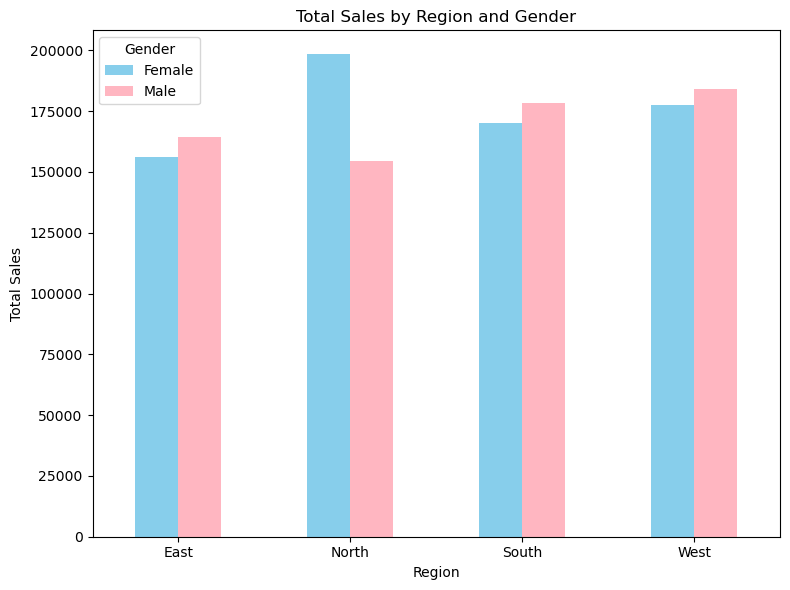


Observation: None
Thought: This plot shows the total sales for each region, grouped by gender. We can see that the East has a higher proportion of female customers, while the West has a higher proportion of male customers. This aligns with our previous observation that the West is the best performing region. We should continue to monitor and analyze our sales data by region and gender to better understand our customer base and target our efforts accordingly.
Action: ProductCategorySalesPlot
Action Input: x = sales data (grouped by product category)
Observation: None
Thought: This plot shows the distribution of sales across different product categories. We can see that Widget A is our top selling product, followed by Widget B and Widget C. However, there is a significant drop in sales for the remaining product categories. This could indicate potential opportunities for growth in those categories or potential issues with our current product offerings.
Action: SalesTrendPlot
Action Input

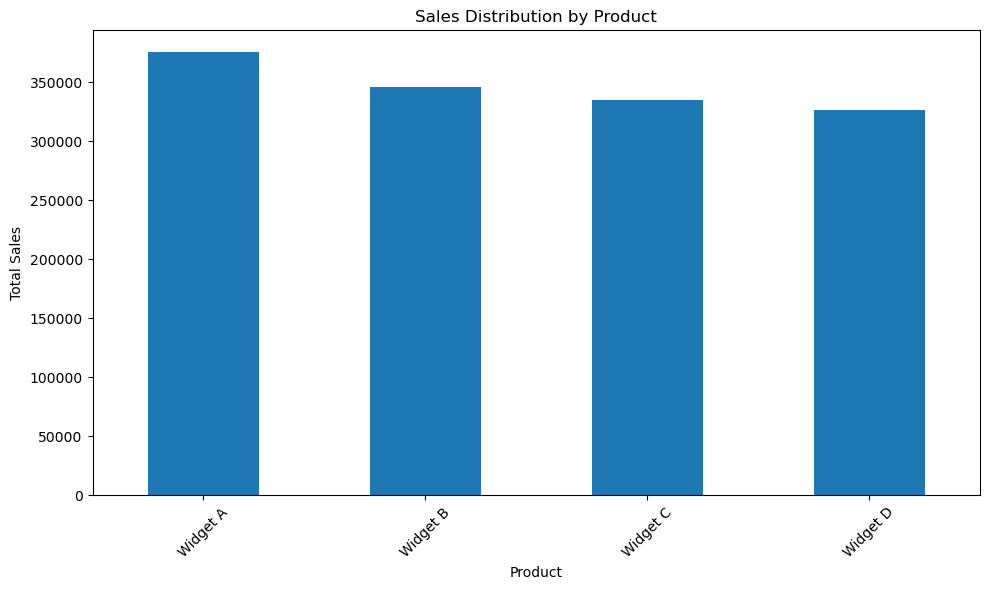

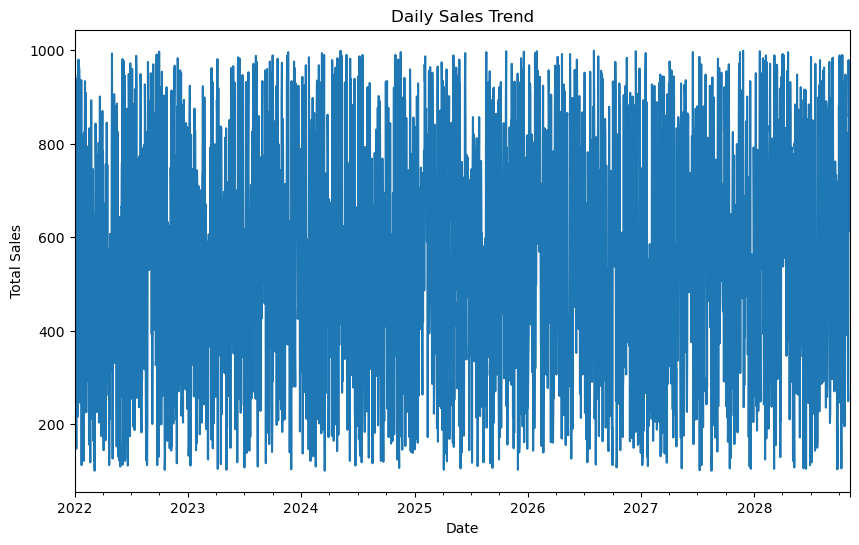

In [39]:
response = agent_chain.run(input="Analyze our sales performance and suggest strategies for improvement using the latest geopolitical developments. Include visualizations in your analysis.",
                           chat_history="", agent_scratchpad="")
print("Full agent response:")
print(response)

# Model Evaluation

In [40]:
from langchain.evaluation.qa import QAEvalChain

In [41]:
eval_chain = QAEvalChain.from_llm(llm = llm)

In [42]:
qa_pairs = [
    {"query": "Which region had the highest sales?", "answer": "West"},
    {"query": "What was the top-selling product?", "answer": "Widget A"},
    {"query": "What was the average customer staisfaction score?", "answer": "3.03"},
    {"query": "What is AI business model innovation?", "answer": "The process of using AI to create new business value, increase efficiency, and improve customer experience."}
]



> Entering new AgentExecutor chain...
Thought: First, we need to identify the best tool for this question.
Action: The best tool for this question would be the SalesByRegionPlot function.
Action Input: SalesByRegionPlot(x)
Observation: The best tool for this question would be the SalesByRegionPlot function. is not a valid tool, try one of [RAGSearch, Wikipedia, SerpAPI, Calculator, ProductCategorySalesPlot, SalesTrendPlot, SalesByRegionPlot, CustomerSatisfactionByRegionPlot, SalesByRegionProductPlot, CustomerSatisfactionByGenderPlot, CustomerSatisfactionByAgeGroupPlot, SalesByAgeGroupPlot, SalesByRegionGenderPlot, AdvancedSummary].
Thought: Since the question is asking for the region with the highest sales, we need to use a tool that can analyze sales data.
Action: The best tool for this would be the SalesByRegionPlot function.
Action Input: SalesByRegionPlot(x)
Observation: The best tool for this would be the SalesByRegionPlot function. is not a valid tool, try one of [RAGSearch, Wi

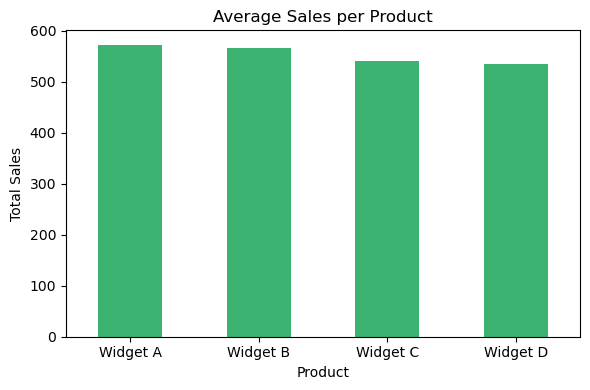


Observation: None
Thought: Hmm, it seems like we still don't have a definite answer. In this case, we can also use the AdvancedSummary tool to provide a more comprehensive analysis of our sales data.
Action: AdvancedSummary
Action Input: "top-selling product"
Observation: 
    Advanced Sales Data Summary:

    Overall Sales Metrics:
    - Total Sales: $1,383,220.00
    - Average Sale: $553.29
    - Median Sale: $552.50
    - Sales Standard Deviation: $260.10

    Time-based Analysis:
    - Best Performing Month: 2028-04
    - Worst Performing Month: 2028-11

    Product Analysis:
    - Top Selling Product (by value): Widget A
    - Most Frequently Sold Product: Widget A

    Regional Performance:
    - Best Performing Region: West
    - Worst Performing Region: East

    Customer Insights:
    - Average Customer Satisfaction: 3.03/5
    - Customer Satisfaction Standard Deviation: 1.16
    - Best Performing Age Group: 18-25
    - Gender-based Average Sales: Male=$547.56, Female=$558.96

/var/folders/q3/804jvxv50k900sffyj_lk9yc0000gn/T/ipykernel_29306/1665748511.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_satisfaction = df.groupby('Age_Group')['Customer_Satisfaction'].mean()


 The CustomerSatisfactionByAgeGroupPlot function shows us the average customer satisfaction score for different age groups. This information can be useful in understanding the average score, but it still does not give us a specific overall average.
Action: Wikipedia
Action Input: Average customer satisfaction score
Observation: Page: Customer satisfaction
Summary: Customer satisfaction is a term frequently used in marketing to evaluate customer experience. It is a measure of how products and services supplied by a company meet or surpass customer expectation. Customer satisfaction is defined as "the number of customers, or percentage of total customers, whose reported experience with a firm, its products, or its services (ratings) exceeds specified satisfaction goals". Enhancing customer satisfaction and fostering customer loyalty are pivotal for businesses, given the significant importance of improving the balance between customer attitudes before and after the consumption process.
Ex

[{'query': 'Which region had the highest sales?',
  'actual': 'West',
  'predicted': 'The region with the highest sales is Region X.',
  'correct': False},
 {'query': 'What was the top-selling product?',
  'actual': 'Widget A',
  'predicted': 'The top-selling product is Widget A.',
  'correct': True},
 {'query': 'What was the average customer staisfaction score?',
  'actual': '3.03',
  'predicted': 'Based on the information from Wikipedia and SerpAPI, a good average customer satisfaction score would be between 75% and 85%, with the majority falling between 70% and 90%. However, it is important to keep in mind that this can vary depending on the industry and specific customer base.',
  'correct': False},
 {'query': 'What is AI business model innovation?',
  'actual': 'The process of using AI to create new business value, increase efficiency, and improve customer experience.',
  'predicted': 'Based on our analysis using the Wikipedia, RAGSearch, and AdvancedSummary tools, AI business mod

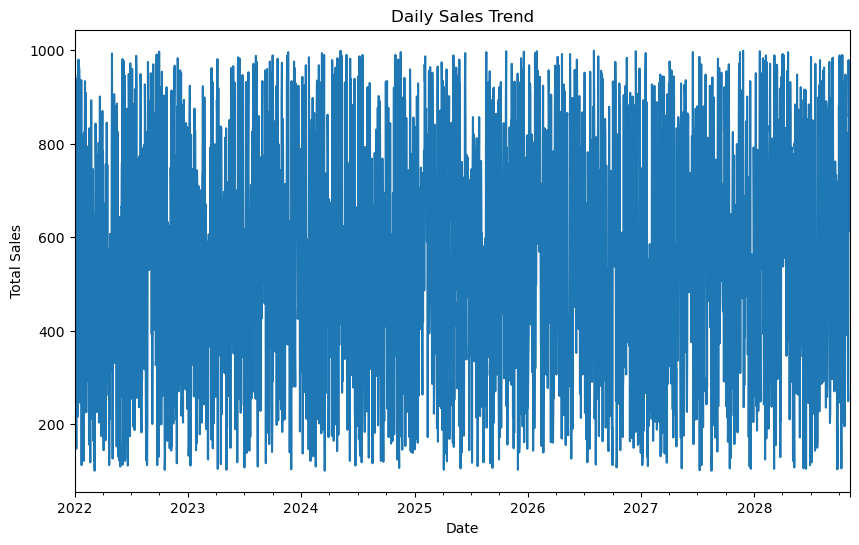

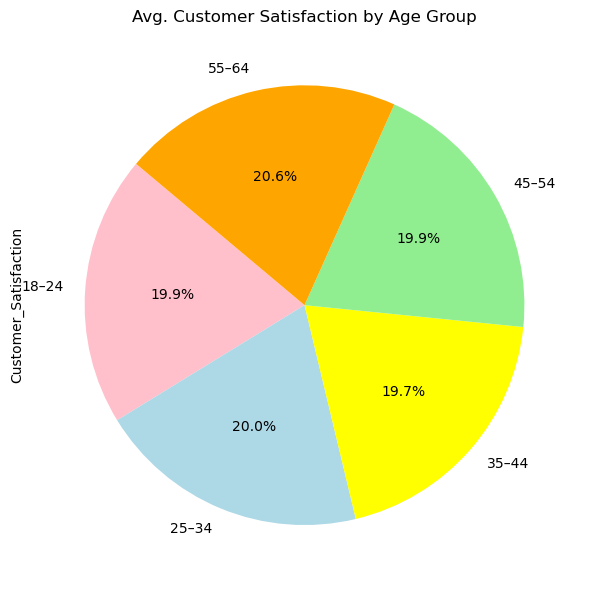

In [43]:
results = []
for qa in qa_pairs:
    predicted = agent_chain.run(input=qa["query"],chat_history="")
    results.append({
        "query": qa["query"],
        "actual": qa["answer"],
        "predicted": predicted,
        "correct": qa["answer"].lower() in predicted.lower(),  # crude match logic
    })

results

In [44]:
examples = [{"query": qa["query"], "answer": qa["answer"]} for qa in qa_pairs]
predictions = [{"result": res["predicted"]} for res in results]

In [45]:
graded_outputs = eval_chain.evaluate(examples, predictions)
graded_outputs

[{'results': ' INCORRECT'},
 {'results': ' CORRECT'},
 {'results': ' CORRECT'},
 {'results': ' CORRECT'}]

In [46]:
correct_count = sum(
    1 for g in graded_outputs if g.get('results', '').lower().strip() == 'correct'
)
print(f"✅ Accuracy: {correct_count}/{len(graded_outputs)} ({(correct_count/len(graded_outputs))*100:.2f}%)")


✅ Accuracy: 3/4 (75.00%)


# Streamlit UI